# Contents:

[Background and Objective](#Background)

[Import and Warehouse data](#Data_Import)

[Data Cleansing](#Data_Cleansing)

[Data Analysis & Visualisation](#Analysis_Visualisation)

[Machine Learning](#ML)

[Outcomes](#Outcomes)

[Improvisation](#Imp)


<a id='the_destination'></a>

<a id='Background'></a>
# Background and Objective

• DOMAIN: Automobile

• CONTEXT: The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes

• DATA DESCRIPTION: The data concerns city-cycle fuel consumption in miles per gallon

• Attribute Information:
1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

• PROJECT OBJECTIVE: Goal is to cluster the data and treat them as individual datasets to train Regression models to predict ‘mpg’

In [1]:
import numpy as np
import pandas as pd
import json

# Import libraries for Visualisation

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

# Libraries for Statistics and Models

from scipy.stats import zscore
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score


# To see multiple outputs together

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<a id='Data_Import'></a>
# Import and Warehouse data

#### Import all the given datasets and explore shape and size

In [2]:
# Import the two data sets for the given problem

car_attributes = pd.read_json (r'Part1 - Car-Attributes.json')
car_names = pd.read_csv('Part1 - Car name.csv')

In [3]:
# Shape and size of each data

print("Car Attributes data has {} rows / observations and {} columns / features".format(car_attributes.shape[0],car_attributes.shape[1]))
print()
print("Car names data has {} rows / observations and {} columns / features".format(car_names.shape[0],car_names.shape[1]))
print()
print('The size of Car Attributes data is:', car_attributes.size)
print()
print('The size of Car names data is:', car_names.size)

Car Attributes data has 398 rows / observations and 8 columns / features

Car names data has 398 rows / observations and 1 columns / features

The size of Car Attributes data is: 3184

The size of Car names data is: 398


#### Merge all datasets onto one and explore final shape and size

Since both data-sets have same number of rows we assume that Car Names in one data corresponds to the the observations Car Attributes in the other data.

With the above assumption we will merge the two data-sets horizontally using 'join'. 'Join' combines dataframes using the index to identify common entries.

In [4]:
# Merging two datasets

cardf = car_attributes.join(car_names,how='inner')


In [5]:
# Exploring Shape and Size of Final data

print("Final data has {} rows / observations and {} columns / features".format(cardf.shape[0],cardf.shape[1]))
print()
print('The size of Final data is:', cardf.size)

Final data has 398 rows / observations and 9 columns / features

The size of Final data is: 3582


#### Export the final dataset and store it on local machine in .csv, .xlsx and .json format for future use

In [6]:
# Export to csv

cardf.to_csv('C:/Users/User/Documents/AIML/05. Unsupervised Techniques/Assignment/Part1/Car_Data_csv.csv')

# Export to excel

cardf.to_excel('C:/Users/User/Documents/AIML/05. Unsupervised Techniques/Assignment/Part1/Car_Data_excel.xls')

# Export to json

cardf.to_json('C:/Users/User/Documents/AIML/05. Unsupervised Techniques/Assignment/Part1/Car_Data_json.json')

#### Import the data from above steps into python

In [7]:
# Import from csv

cardf_from_csv = pd.read_csv('Car_Data_csv.csv')

# Import from excel

cardf_from_excel = pd.read_excel('Car_Data_excel.xls')

# Import from json

cardf_from_json = pd.read_json (r'Car_Data_json.json')

In [8]:
cardf_from_csv.head()
cardf_from_excel.head()
cardf_from_json.head()

,Unnamed: 0,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


,Unnamed: 0,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


<a id='Data_Cleansing'></a>
# Data Cleansing

#### Missing/incorrect value treatment

Before we look into missing values, we will check for duplicate rows in the data and will remove if there's any.

In [9]:
##Identify duplicates records in the data
dupes = cardf.duplicated()
if sum(dupes) == 0:
    print("There is no duplicates in the data")
else:
    cardf = cardf.drop_duplicates()
    dupes_check = cardf.duplicated()
    sum(dupes_check)

There is no duplicates in the data


There is no duplicate rows in the data - now we move to clean missing data

In [10]:
# number of missing values (only the ones recognised as missing values) in each of the attributes
pd.DataFrame( cardf.isnull().sum(), columns= ['Number of missing values'])

,Number of missing values
mpg,0
cyl,0
disp,0
hp,0
wt,0
acc,0
yr,0
origin,0
car_name,0


The above shows there's no missing values. However, we will still check the data types of each variables to ensure that there is no hidden missing values in form of strings.

In [11]:
#Checking data types for all variables

cardf.dtypes

mpg         float64
cyl           int64
disp        float64
hp           object
wt            int64
acc         float64
yr            int64
origin        int64
car_name     object
dtype: object

* There seems to be some issue with the variable hp. As per description provided we expect 'hp' to be numerical i.e. either float or int.
* Hence, we now will now check the presence of any string by using isdigit()

In [12]:
# isdigit() on 'hp' 
hpIsDigit = pd.DataFrame(cardf.hp.str.isdigit())

# show only the rows where there's strings in hp
cardf[hpIsDigit['hp'] == False]

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


* We will check the percentage of observations where there is incorrect data and post that will decide whether we will delete the data or impute the values.
* Also, we will run a 5 point summary to check if there is any incorrect values example a negative value etc.

In [13]:
print("Percentage of '?'s in hp column:",100*((cardf['hp'] == '?')).sum()/len(cardf.index))

Percentage of '?'s in hp column: 1.5075376884422111


In [14]:
cardf.describe()

,mpg,cyl,disp,wt,acc,yr,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


* There is no incorrect values and also the percentage of missing data in 'hp' column is only 1.5. However, we will not drop them but in subsequent steps will replace it with median.
* Also, we will remove the variable car_name as it's unique for each instance and is an identifier.
* The data collection time is not given to us. Hence, we cannot calculate the age of car. We could have used the current year to calculate the age of car wrt current time, however this may be very misleading. So, we drop the year variable as well.

In [15]:
#dropping car_name 

cardf = cardf.drop(['car_name','yr'], axis=1)

In [16]:
# Replace missing values with NaN

cardf = cardf.replace('?', np.nan)
cardf[hpIsDigit['hp'] == False]

,mpg,cyl,disp,hp,wt,acc,origin
32,25.0,4,98.0,NaN,2046,19.0,1
126,21.0,6,200.0,NaN,2875,17.0,1
330,40.9,4,85.0,NaN,1835,17.3,2
336,23.6,4,140.0,NaN,2905,14.3,1
354,34.5,4,100.0,NaN,2320,15.8,2
374,23.0,4,151.0,NaN,3035,20.5,1


In [17]:
# Replace missing values with median

medianFiller = lambda x: x.fillna(x.median())
cardf = cardf.apply(medianFiller,axis=0)

cardf['hp'] = cardf['hp'].astype('float64')

#### Outlier Treatment

We now check for outliers. Since we will be performing k-means it is necessary to treat outliers, if any.

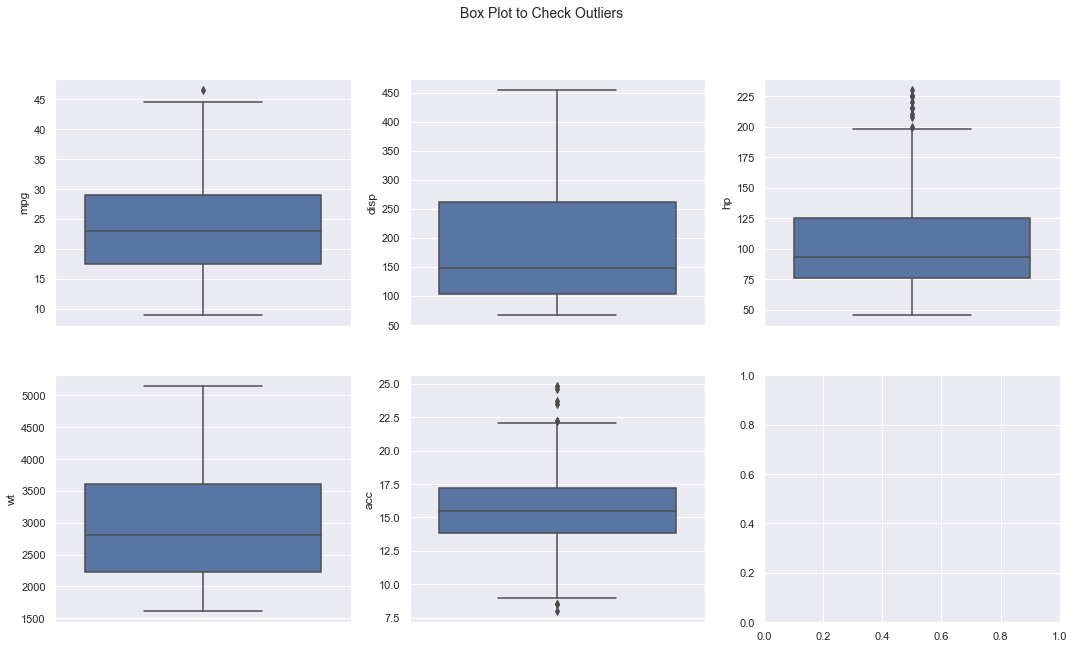

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10));

fig.suptitle('Box Plot to Check Outliers', size = 14);

sns.boxplot(ax=axes[0, 0], data=cardf,y='mpg');
sns.boxplot(ax=axes[0, 1], data=cardf,y='disp');
sns.boxplot(ax=axes[0, 2], data=cardf,y='hp');
sns.boxplot(ax=axes[1, 0], data=cardf,y='wt');
sns.boxplot(ax=axes[1, 1], data=cardf,y='acc');



There are some outliers in the mpg, hp and acceleration features. We will do an outlier treatment on them.

In [19]:
# Outlier Treatment

Q1 = cardf.quantile(0.25)
Q3 = cardf.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Replace every outlier on the lower side by the lower whisker
for i, j in zip(np.where(cardf < Q1 - 1.5 * IQR)[0], np.where(cardf < Q1 - 1.5 * IQR)[1]): 
    
    whisker  = Q1 - 1.5 * IQR
    cardf.iloc[i,j] = whisker[j]
    
    
#Replace every outlier on the upper side by the upper whisker    
for i, j in zip(np.where(cardf > Q3 + 1.5 * IQR)[0], np.where(cardf > Q3 + 1.5 * IQR)[1]):
    
    whisker  = Q3 + 1.5 * IQR
    cardf.iloc[i,j] = whisker[j]
    

mpg         11.50
cyl          4.00
disp       157.75
hp          49.00
wt        1384.25
acc          3.35
origin       1.00
dtype: float64


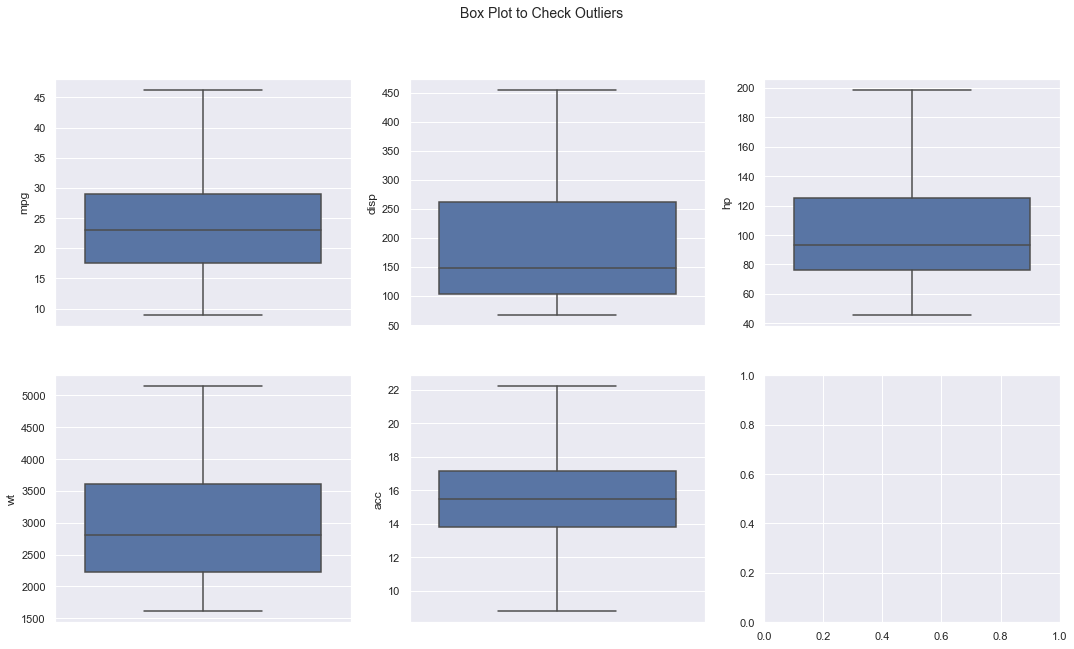

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10));

fig.suptitle('Box Plot to Check Outliers', size = 14);

sns.boxplot(ax=axes[0, 0], data=cardf,y='mpg');
sns.boxplot(ax=axes[0, 1], data=cardf,y='disp');
sns.boxplot(ax=axes[0, 2], data=cardf,y='hp');
sns.boxplot(ax=axes[1, 0], data=cardf,y='wt');
sns.boxplot(ax=axes[1, 1], data=cardf,y='acc');



* The outliers have now been removed - this may have changed the distribution of those features.

<a id='Analysis_Visualisation'></a>
# Data Analysis & Visualisation

We will create two new features : displacement per cycle and power to weight ratio.

In [21]:
# Creating new features

cardf['dispercyl'] = cardf['disp'] / cardf['cyl']
cardf['pw_ratio'] = cardf['hp'] / cardf['wt']

In [22]:
cardf.head()

,mpg,cyl,disp,hp,wt,acc,origin,dispercyl,pw_ratio
0,18.0,8,307.0,130.0,3504,12.0,1,38.375,0.037100
1,15.0,8,350.0,165.0,3693,11.5,1,43.750,0.044679
2,18.0,8,318.0,150.0,3436,11.0,1,39.750,0.043655
3,16.0,8,304.0,150.0,3433,12.0,1,38.000,0.043694
4,17.0,8,302.0,140.0,3449,10.5,1,37.750,0.040591


In [23]:
cardf.describe()

,mpg,cyl,disp,hp,wt,acc,origin,dispercyl,pw_ratio
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.513693,5.454774,193.425879,103.790201,2970.424623,15.552010,1.572864,33.365054,0.034771
std,7.813400,1.701004,104.269838,36.770468,846.841774,2.693089,0.802055,8.687268,0.005654
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.800000,1.000000,17.000000,0.020557
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,1.000000,24.625000,0.030851
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,1.000000,33.333333,0.034285
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,2.000000,38.916667,0.038168
max,46.250000,8.000000,455.000000,198.500000,5140.000000,22.200000,3.000000,56.875000,0.064323


* Compared to original data there have been slight changes in the variables which have been treated, e.g. mpg, acc etc.

#### Distribution of the Numeric Variables

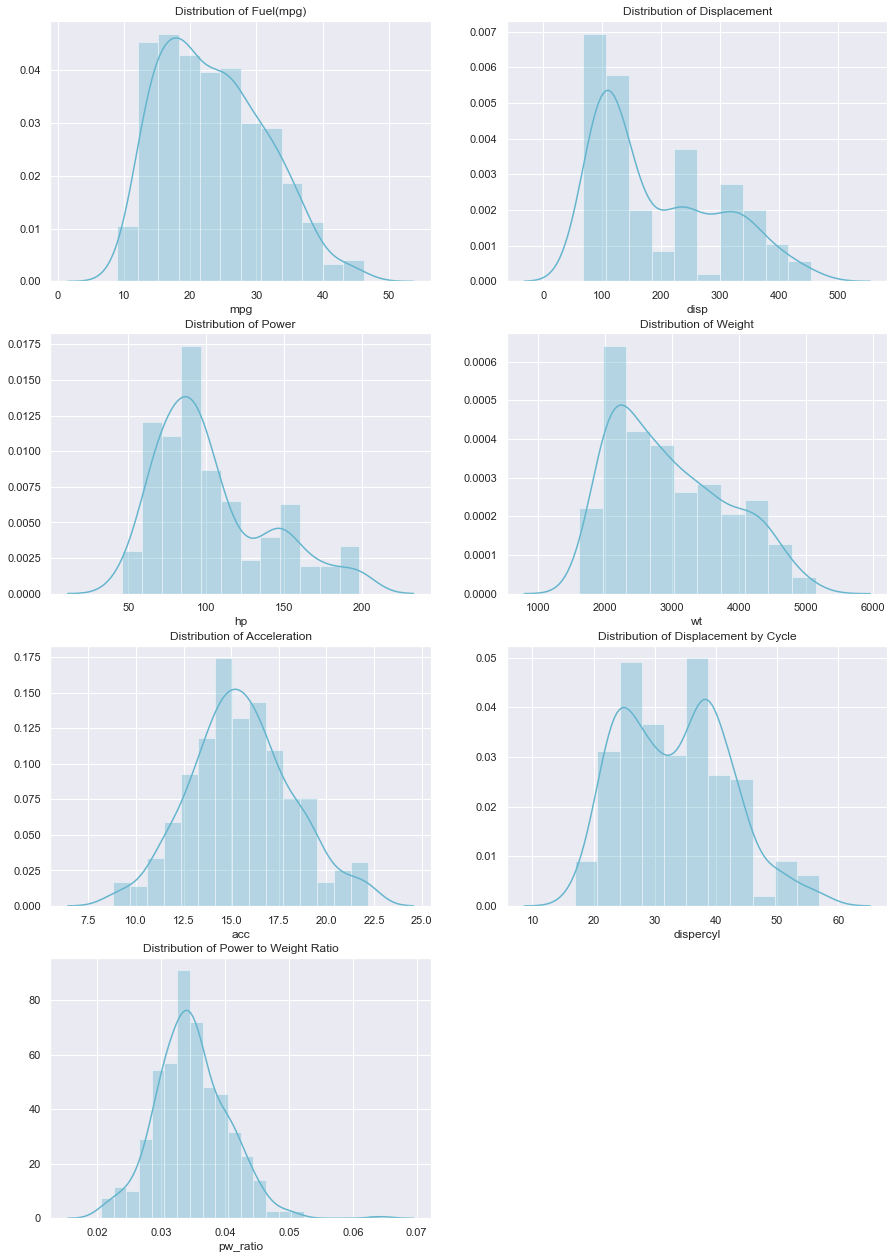

In [24]:
sns.set(rc={"figure.figsize": (15, 45)});

plt.subplot(8,2,1);
ax=sns.distplot(cardf.mpg, color='c');
ax.set_title('Distribution of Fuel(mpg)');


plt.subplot(8,2,2);
ax=sns.distplot(cardf.disp, color='c');
ax.set_title('Distribution of Displacement');

plt.subplot(8,2,3);
ax=sns.distplot(cardf.hp, color='c');
ax.set_title('Distribution of Power');

plt.subplot(8,2,4);
ax=sns.distplot(cardf.wt, color='c');
ax.set_title('Distribution of Weight');

plt.subplot(8,2,5);
ax=sns.distplot(cardf.acc, color='c');
ax.set_title('Distribution of Acceleration');


plt.subplot(8,2,6);
ax=sns.distplot(cardf.dispercyl, color='c');
ax.set_title('Distribution of Displacement by Cycle');

plt.subplot(8,2,7);
ax=sns.distplot(cardf.pw_ratio, color='c');
ax.set_title('Distribution of Power to Weight Ratio');


* Average fuel consumption is 23 mpg with slight postive skeweness and maximum concentration around 20 and 25 mpg.
* Accelaration follows a symmetric distribution with maximum concentration between 15-17 unit with an average accelaration of 15.5 units.
* Displacement, power(hp) and weight are postive skewed.
* Displacement, Power indicate 3 clusters and weight indicates 2.
* The derived feature displacement per cycle has two modes, incdicating two distinct clusters.
* The other derived feature power to weight ratio has a meandering tail suggesting presence of few outliers. Otherwise, it is symmeytric.

#### Distribution of Categorical Variables

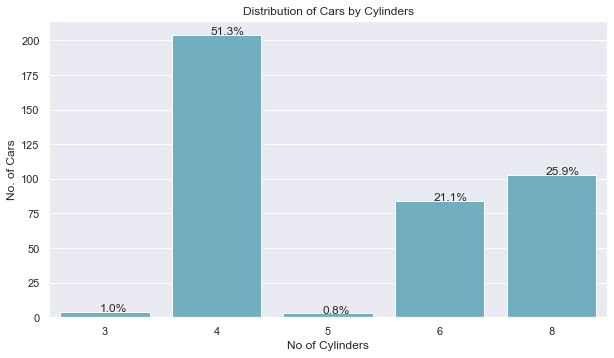

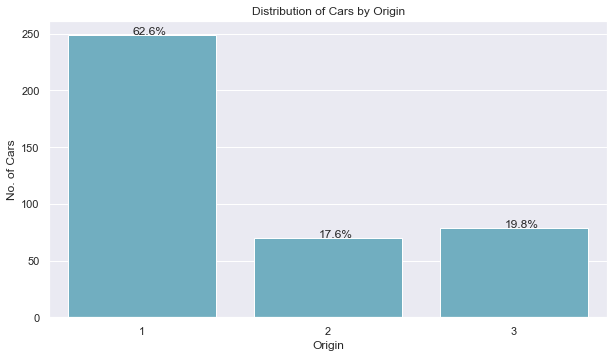

In [25]:
# Function to add percentage values to chart

def add_percentage(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))
    plt.show();

sns.set(rc={"figure.figsize": (10, 12)});
plt.subplot(2,1,1)

ax=sns.countplot(cardf['cyl'], color='c');
plt.xlabel('No of Cylinders');
plt.ylabel('No. of Cars');
plt.title('Distribution of Cars by Cylinders');
add_percentage(ax,cardf.cyl);


plt.subplot(2,1,2)

ax=sns.countplot(cardf['origin'], color='c');
plt.xlabel('Origin');
plt.ylabel('No. of Cars');
plt.title('Distribution of Cars by Origin');
add_percentage(ax,cardf.origin);

* 51% cars have 4 cylinders, 21% and 26% have respectively 6 and 8 cylinders. It seems that cars mostly have even no of cylinders.
* Around 63% cars are from Origin 1, while Origin 2 and 3 together account for 37% of cars.

#### Bivariate and Multi-variate Analysis

Since fuel consumption (mpg) is the target variable we will study the relationship of the same with all other continuous variables and compare against the different origins and cylinders.

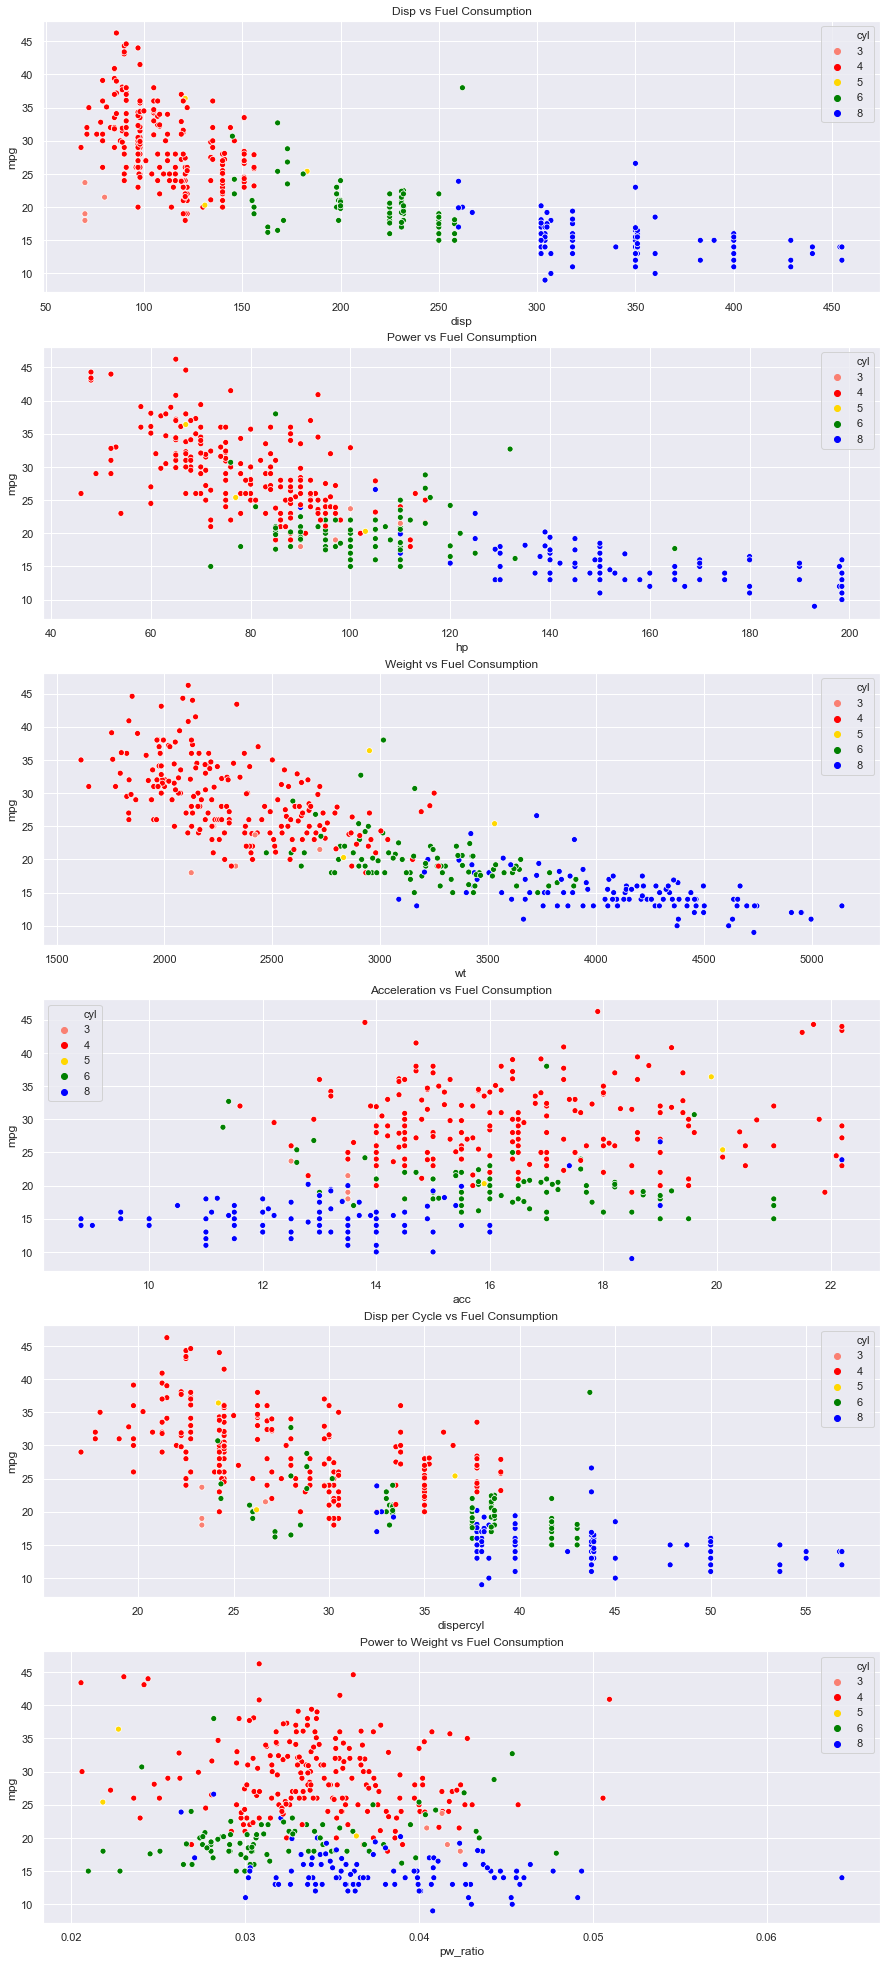

In [26]:
# Scatter-plot of study by Cylinders

sns.set(rc={"figure.figsize": (15, 35)});

plt.subplot(6,1,1);
ax=sns.scatterplot(data=cardf, x='disp',y='mpg',hue='cyl',palette=['salmon','red','gold','green','blue']);
ax.set_title('Disp vs Fuel Consumption');


plt.subplot(6,1,2);
ax=sns.scatterplot(data=cardf, x='hp',y='mpg',hue='cyl',palette=['salmon','red','gold','green','blue']);
ax.set_title('Power vs Fuel Consumption');

plt.subplot(6,1,3);
ax=sns.scatterplot(data=cardf, x='wt',y='mpg',hue='cyl',palette=['salmon','red','gold','green','blue']);
ax.set_title('Weight vs Fuel Consumption');

plt.subplot(6,1,4);
ax=sns.scatterplot(data=cardf, x='acc',y='mpg',hue='cyl',palette=['salmon','red','gold','green','blue']);
ax.set_title('Acceleration vs Fuel Consumption');

plt.subplot(6,1,5);
ax=sns.scatterplot(data=cardf, x='dispercyl',y='mpg',hue='cyl',palette=['salmon','red','gold','green','blue']);
ax.set_title('Disp per Cycle vs Fuel Consumption');


plt.subplot(6,1,6);
ax=sns.scatterplot(data=cardf, x='pw_ratio',y='mpg',hue='cyl',palette=['salmon','red','gold','green','blue']);
ax.set_title('Power to Weight vs Fuel Consumption');



* Fuel consumption has a negative correlation with Displacement, Power and Weight.
* For all the above comparisons we find 3 clusters respectively, for 4, 6 and 8 cylinders.
* For 4 cylinders the fuel consumption is higher, while for 8 the fuel consumption is lowest.
* Though for accelaration we do not see any relationship with fuel consumption, there's presence of two clusters - one for 4 cylinders and one with 8 cylinders.

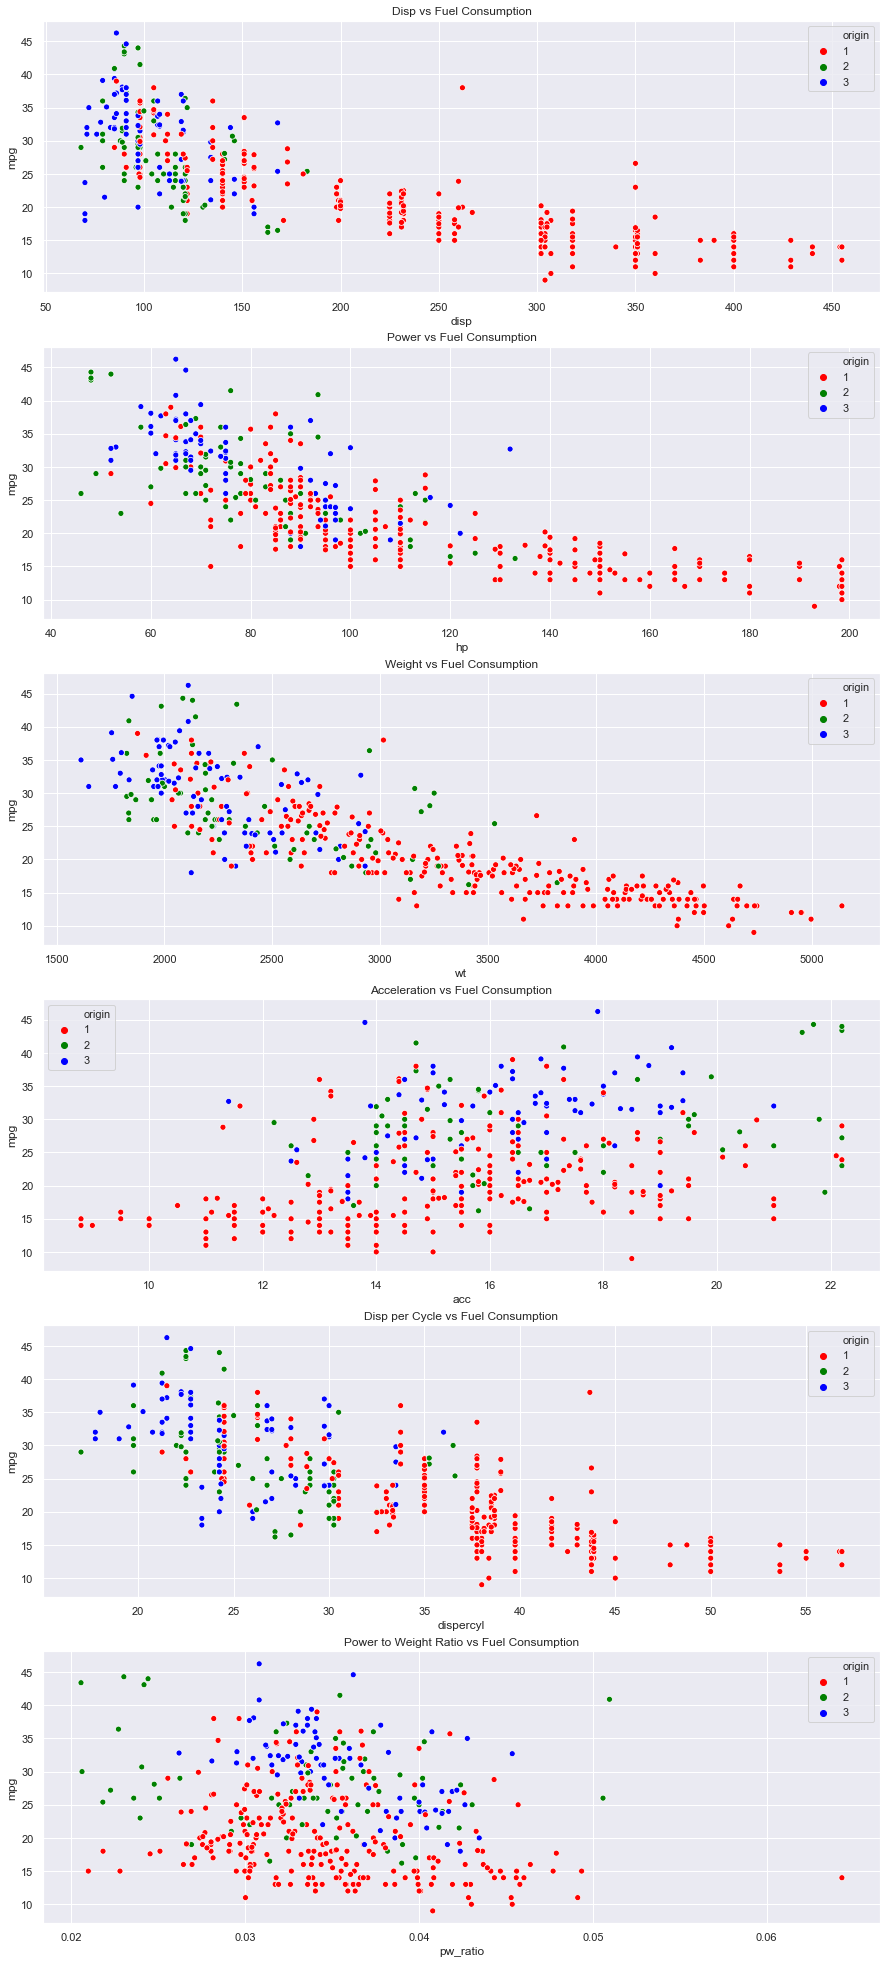

In [27]:
# Scatter plot to study by origin

sns.set(rc={"figure.figsize": (15, 35)});

plt.subplot(6,1,1);
ax=sns.scatterplot(data=cardf, x='disp',y='mpg',hue='origin',palette=['red','green','blue']);
ax.set_title('Disp vs Fuel Consumption');


plt.subplot(6,1,2);
ax=sns.scatterplot(data=cardf, x='hp',y='mpg',hue='origin',palette=['red','green','blue']);
ax.set_title('Power vs Fuel Consumption');

plt.subplot(6,1,3);
ax=sns.scatterplot(data=cardf, x='wt',y='mpg',hue='origin',palette=['red','green','blue']);
ax.set_title('Weight vs Fuel Consumption');

plt.subplot(6,1,4);
ax=sns.scatterplot(data=cardf, x='acc',y='mpg',hue='origin',palette=['red','green','blue']);
ax.set_title('Acceleration vs Fuel Consumption');

plt.subplot(6,1,5);
ax=sns.scatterplot(data=cardf, x='dispercyl',y='mpg',hue='origin',palette=['red','green','blue']);
ax.set_title('Disp per Cycle vs Fuel Consumption');

plt.subplot(6,1,6);
ax=sns.scatterplot(data=cardf, x='pw_ratio',y='mpg',hue='origin',palette=['red','green','blue']);
ax.set_title('Power to Weight Ratio vs Fuel Consumption');



* We have already discussed the relationship between Fuel consumption and some of the independent attributes.
* In terms of the pattern observation against origin - it appears origin 2 and 3 are very similar, however a part of origin 1 is mostly distinct. That segment seems to be that of the better cars in terms of fuel consumption.


Though the feature origin is already in numeric data type, we will enocde it. This will help us to infer better when we do clustering.

In [28]:
# Performing one hot encoding on origin variable.

one_hot = pd.get_dummies(cardf['origin'])
one_hot = one_hot.add_prefix('origin_')

# merge in main data frame
cardf = cardf.join(one_hot)
cardf.head()

,mpg,cyl,disp,hp,wt,acc,origin,dispercyl,pw_ratio,origin_1,origin_2,origin_3
0,18.0,8,307.0,130.0,3504,12.0,1,38.375,0.037100,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,1,43.750,0.044679,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,1,39.750,0.043655,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,1,38.000,0.043694,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,1,37.750,0.040591,1,0,0


In [29]:
cardf = cardf.drop(['origin'], axis=1)

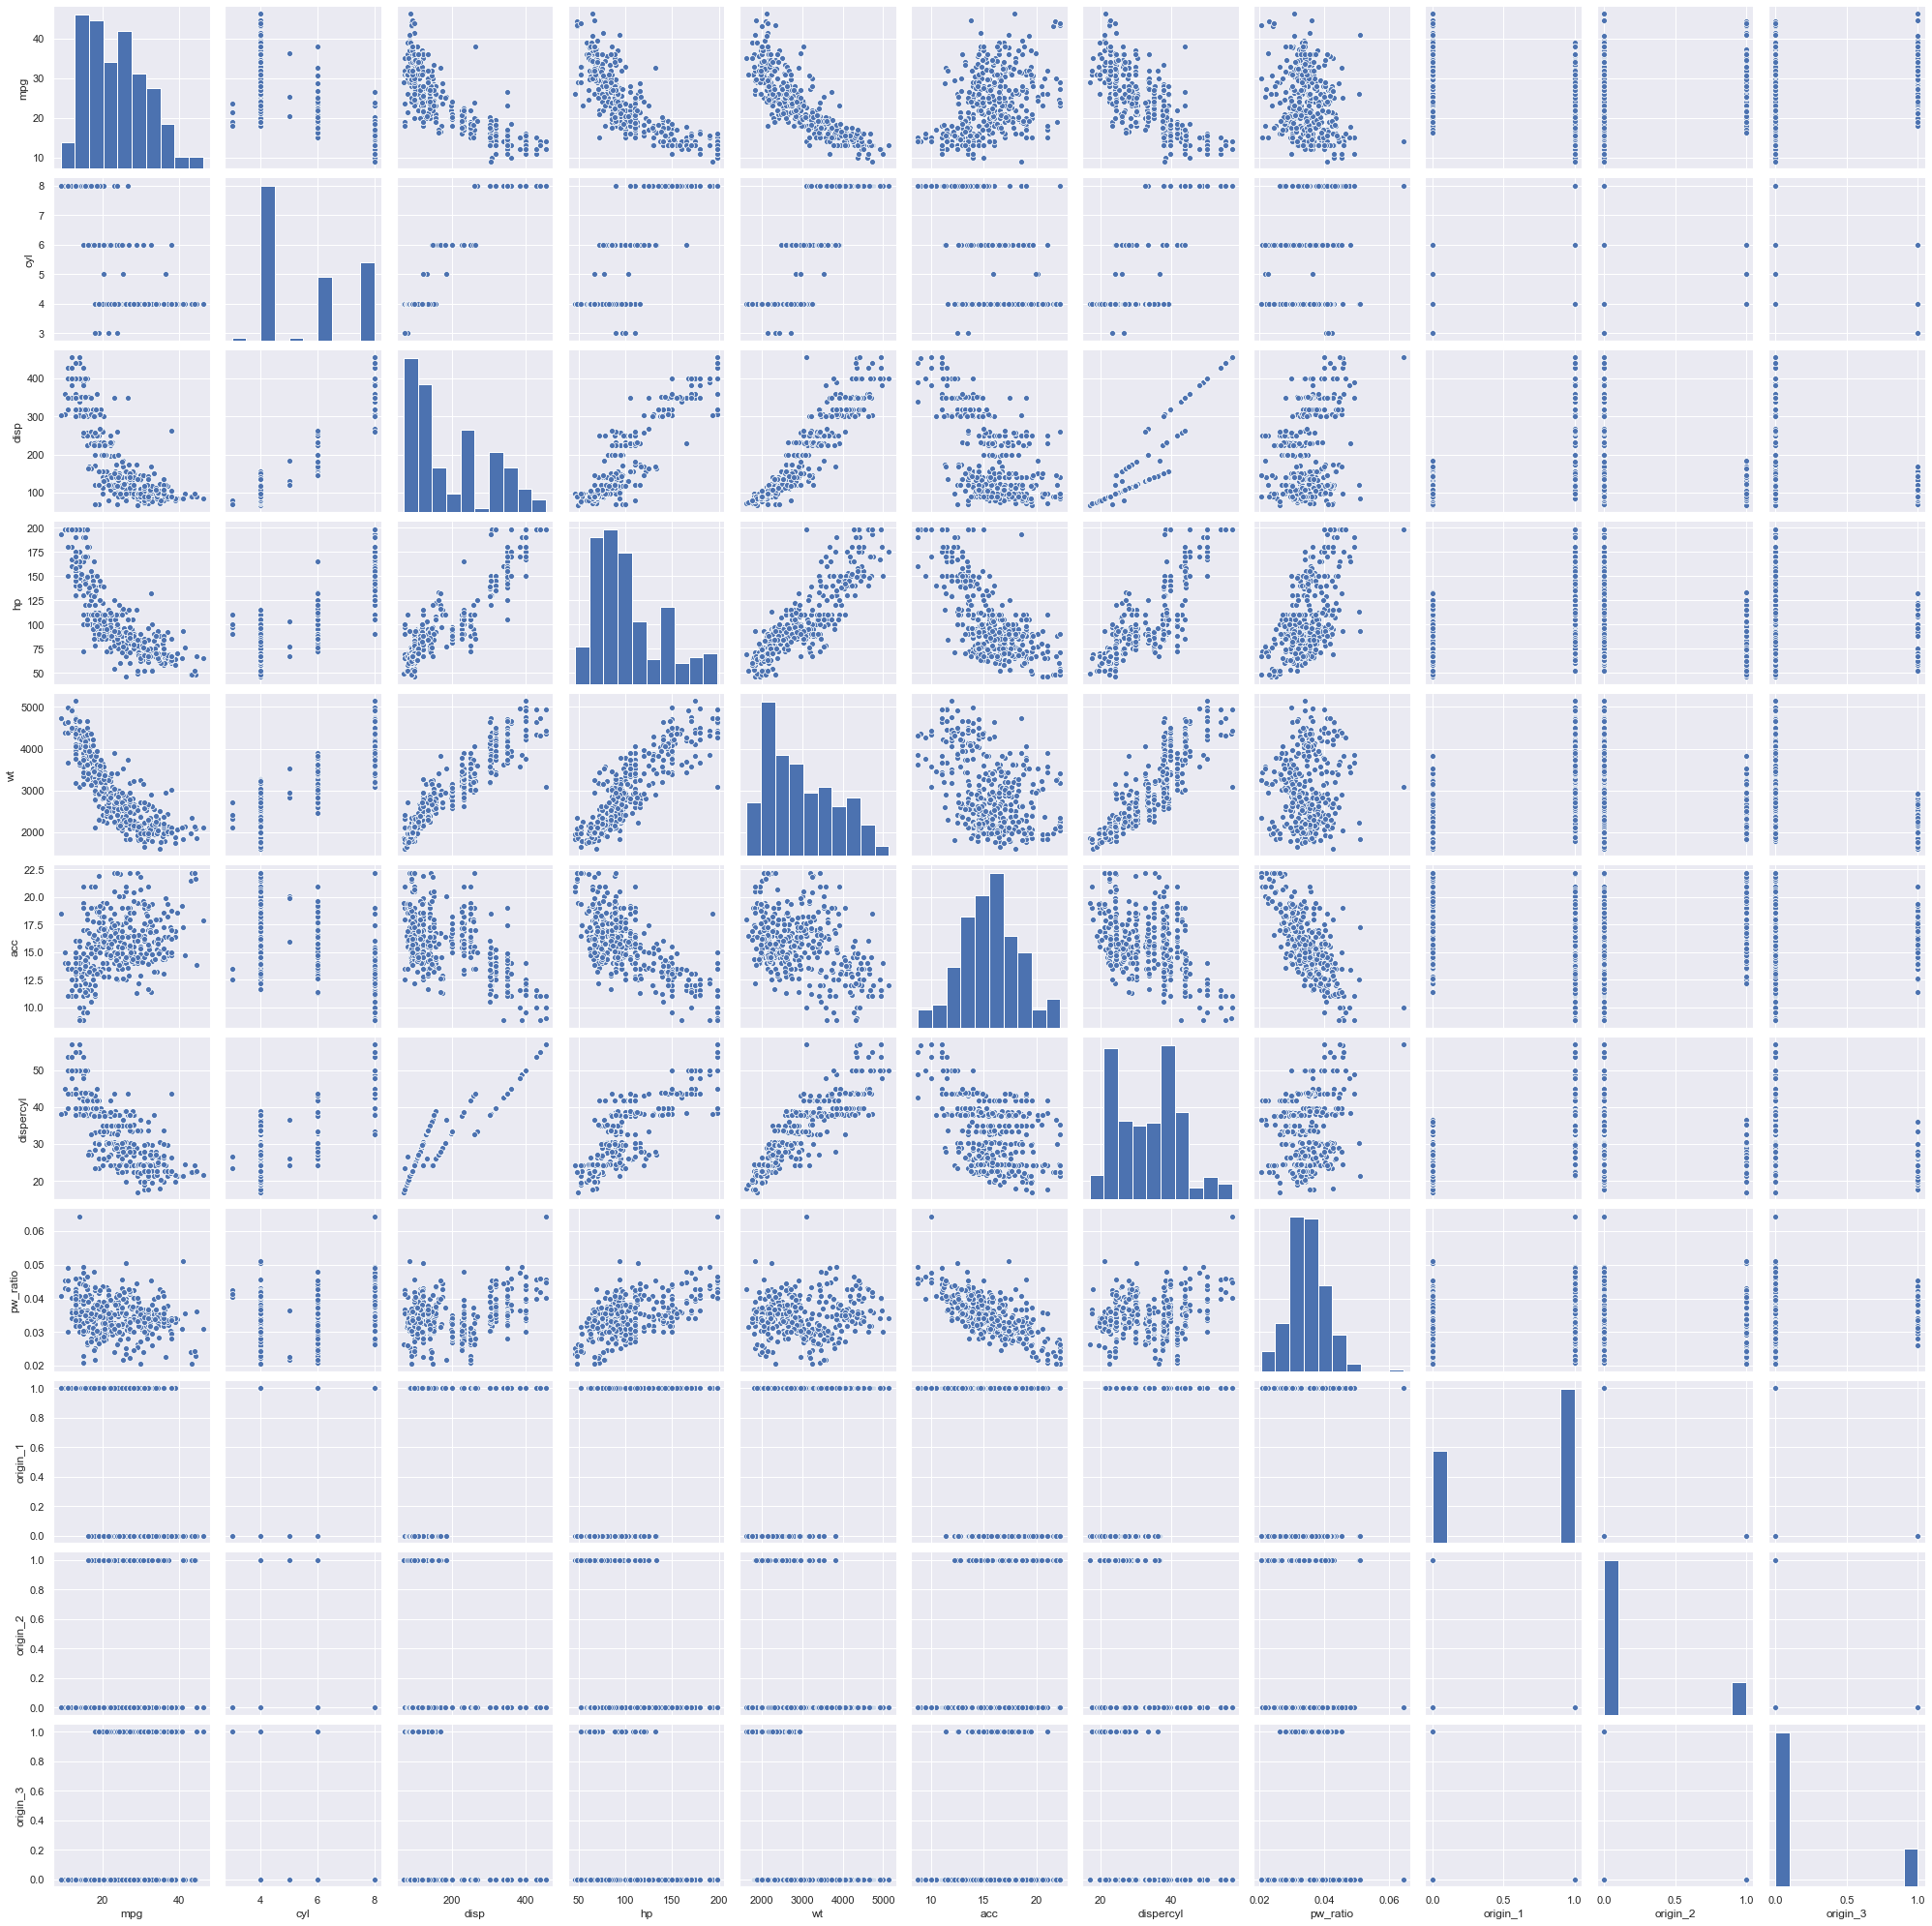

In [30]:
sns.pairplot(data=cardf);

In [32]:
cardf.corr()

,mpg,cyl,disp,hp,wt,acc,dispercyl,origin_1,origin_2,origin_3
mpg,1.000000,-0.775556,-0.804353,-0.785846,-0.831901,0.418333,-0.773465,-0.568234,0.259160,0.442094
cyl,-0.775556,1.000000,0.950721,0.853547,0.896017,-0.509344,0.775244,0.604351,-0.352861,-0.396479
disp,-0.804353,0.950721,1.000000,0.899862,0.932824,-0.548667,0.920171,0.651407,-0.373886,-0.433505
hp,-0.785846,0.853547,0.899862,1.000000,0.874050,-0.692883,0.810011,0.493765,-0.287585,-0.324606
wt,-0.831901,0.896017,0.932824,0.874050,1.000000,-0.422492,0.874531,0.598398,-0.298843,-0.440817
acc,0.418333,-0.509344,-0.548667,-0.692883,-0.422492,1.000000,-0.477945,-0.246391,0.193001,0.114737
dispercyl,-0.773465,0.775244,0.920171,0.810011,0.874531,-0.477945,1.000000,0.695342,-0.380739,-0.480273
origin_1,-0.568234,0.604351,0.651407,0.493765,0.598398,-0.246391,0.695342,1.000000,-0.597198,-0.643317
origin_2,0.259160,-0.352861,-0.373886,-0.287585,-0.298843,0.193001,-0.380739,-0.597198,1.000000,-0.229895
origin_3,0.442094,-0.396479,-0.433505,-0.324606,-0.440817,0.114737,-0.480273,-0.643317,-0.229895,1.000000


* The target variable fuel consumption has very strong negative relationship no. of cylinders, displacement, power and weight. Some of these we have already seen in above scatter plots.
* No of Cylinders is very strongly correlated with displacement, power and weight. Since displacement per cylinders is derived from these features they are stronlgy correlated, with displacement increasing as no of cylinders increases.
* Accelaration has a strong negative correlation with power to weight ratio. This looks strange as the higher your power to weight ratio, the better is the acceleration. Since power to weight ratio is a derived field : there may be some issues in the values of either the power (hp) or the weight variable. We drop the derived variable.

In [31]:
cardf = cardf.drop(['pw_ratio'], axis=1)

<a id='ML'></a>
# Machine Learning

#### K-means Clustering

In [33]:
# Independant variables

X = cardf.drop(['mpg'], axis=1)

# Dependent variable
y = cardf[['mpg']]


In [34]:
# Scaling the data

XScaled=X.apply(zscore)

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


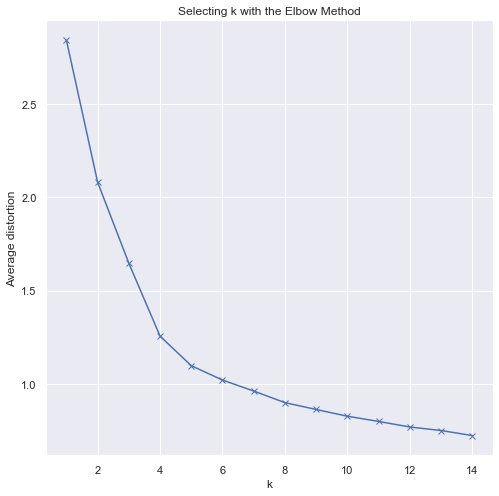

In [35]:
# Finding optimal no of clusters

clusters=range(1,15)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(XScaled)
    prediction=model.predict(XScaled)
    meanDistortions.append(sum(np.min(cdist(XScaled, model.cluster_centers_, 'euclidean'), axis=1)) / XScaled.shape[0])

sns.set(rc={"figure.figsize": (8,8)});
plt.plot(clusters, meanDistortions, 'bx-');
plt.xlabel('k');
plt.ylabel('Average distortion');
plt.title('Selecting k with the Elbow Method');


* We notice a bend at 4 clusters and hence we proceed with the same.

In [36]:
# Kmeans with k = 4
kmeans = KMeans(n_clusters=4, n_init = 5, random_state=12345)
kmeans.fit(XScaled)

KMeans(n_clusters=4, n_init=5, random_state=12345)

In [37]:
# Check the number of data in each cluster

labels = kmeans.labels_
counts = np.bincount(labels[labels>=0])
print(counts)

[101 148  79  70]


In [38]:
# Calculating silhouette_score

silhouette_score(XScaled,labels)

0.5314547916439948

The Silhoutte score is not very high, however being around 0.5, it is good to indicate the clusters have been formed correctly and there is not much overlap.

In [39]:
# Add cluster number to original cars data

cars_new = cardf.copy()

cars_new["group"] = labels
cars_new['group'] = cars_new['group'].astype('category')
cars_new.head()

,mpg,cyl,disp,hp,wt,acc,dispercyl,origin_1,origin_2,origin_3,group
0,18.0,8,307.0,130.0,3504,12.0,38.375,1,0,0,0
1,15.0,8,350.0,165.0,3693,11.5,43.750,1,0,0,0
2,18.0,8,318.0,150.0,3436,11.0,39.750,1,0,0,0
3,16.0,8,304.0,150.0,3433,12.0,38.000,1,0,0,0
4,17.0,8,302.0,140.0,3449,10.5,37.750,1,0,0,0


In [40]:
# Check the number of data in each cluster

print('The no of clusters is each group is :\n')
cars_new['group'].value_counts().sort_index()

print()
print('Percentage wise their distribution is :\n')
cars_new['group'].value_counts(normalize=True).sort_index()

The no of clusters is each group is :



0    101
1    148
2     79
3     70
Name: group, dtype: int64


Percentage wise their distribution is :



0    0.253769
1    0.371859
2    0.198492
3    0.175879
Name: group, dtype: float64

In [41]:
# Profiling the data

clust_profile=cars_new.groupby('group').mean()
clust_profile['freq']=cars_new.group.value_counts().sort_index()
clust_profile

,mpg,cyl,disp,hp,wt,acc,dispercyl,origin_1,origin_2,origin_3,freq
group,,,,,,,,,,,
0,14.832673,7.980198,346.405941,157.975248,4122.930693,12.797030,43.396040,1,0,0,101
1,23.666892,5.067568,177.314189,90.412162,2842.601351,16.569595,34.371340,1,0,0,148
2,30.446203,4.101266,102.708861,79.835443,2221.227848,16.172152,24.991561,0,0,1,79
3,27.891429,4.157143,109.142857,80.928571,2423.300000,16.675714,26.214286,0,1,0,70


* Cluster 0 : Low on Fuel Consumption, High on number of cylinders Displacement, Power and Weight, Presence only in Origin 1 These may be high-end / luxury cars.
* Cluster 1 : Low to Medium Fuel Consumption, Medium to High on most predictors, Presence only in Origin 1. These may be mid-segment cars belonging to Origin 1.
* Cluster 2 : High on Fuel Consumption, Low on number of cylinders Displacement, Power and Weight, Presence only in Origin 3 These may be mid-segment or low-end cars.
* Cluster 3 : Medium to High Fuel Consumption, Low to Medium on other features, Presence only in Origin 2. These may be low-end cars.

From the above clustering we conclude that:

* Most of the high-end cars are from Origin 1 (we saw this even in our EDA).
* Most of the mid-segment or low-segment cars are from Origin 2 and 3.

* The maximum observations (37%) are in Cluster 1, while 25% are in Cluster 0. Cluster 2 and Cluster 3 contain respectively 20% and 17% observations.

#### Hierarchical Clustering

We first check the Cophenet index (a measure of the correlation between the distance of points in feature space and distance on dendrogram). Since, closer the index is to 1, better is the clustering, we will move ahead with that linkage for which it is highest.

In [42]:
# Cophenet index for different linkages

Zs = linkage(XScaled, metric='euclidean', method='single')
c, coph_dists = cophenet(Zs , pdist(XScaled))

print( 'Cophenet index for single linkage is',c)

Zc = linkage(XScaled, metric='euclidean', method='complete')
c, coph_dists = cophenet(Zc , pdist(XScaled))

print( 'Cophenet index for complete linkage is',c)


Za = linkage(XScaled, metric='euclidean', method='average')
c, coph_dists = cophenet(Za , pdist(XScaled))

print( 'Cophenet index for average linkage is',c)

Cophenet index for single linkage is 0.6831721839308045
Cophenet index for complete linkage is 0.7430253785708724
Cophenet index for average linkage is 0.7788581902788876


Cophenet index is highest for average linkage. So, we will try first with average linkage.

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Agglomerative Hierarchical Clustering Dendogram')

Text(0.5, 0, 'sample index')

Text(0, 0.5, 'Distance')

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [10.0, 10.0, 33.75, 33.75],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [120.0, 120.0, 140.0, 140.0],
  [105.0, 105.0, 130.0, 130.0],
  [155.0, 155.0, 165.0, 165.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [160.0, 160.0, 182.5, 182.5],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [235.0, 235.0, 245.0, 245.0],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [265.0, 265.0, 282.5, 282.5],
  [255.0, 255.0, 273.75, 273.75],
  [240.0, 240.0, 264.375, 264.375],
  [305.0, 305.0, 315.0, 315.0],
  [252.1875, 252.1875, 310.0, 310.0],
  [212.5, 212.5, 281.09375, 281.09375],
  [171.25, 171.25, 246.796875, 246.796875],
  [117.5, 117.5, 209.0234375, 209.0234375],
  [73.75, 73.75, 163.26171875, 163.26171875],
  [3

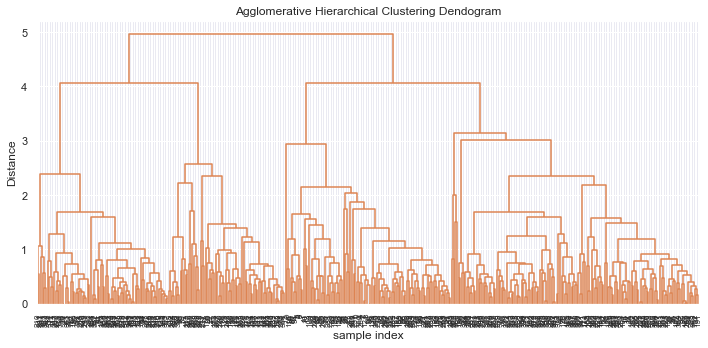

In [43]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Za, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

* The dendogram shows 2 broad clusters, which are again divided into 2 sub-clusters. We can either go by 2 clusters or by 4 clusters.

In [44]:
# Fitting Hierarchical Clustering : with 2 clusters

model = AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='average')
model.fit(XScaled)

# Assigning groups in main data

cars_new1=cardf.copy()

cars_new1['labels'] = model.labels_

# Profiling

group_profile=cars_new1.groupby('labels').mean()
group_profile['freq']=cars_new1.labels.value_counts().sort_index()
group_profile

AgglomerativeClustering(linkage='average')

,mpg,cyl,disp,hp,wt,acc,dispercyl,origin_1,origin_2,origin_3,freq
labels,,,,,,,,,,,
0,20.083534,6.248996,245.901606,117.817269,3361.931727,15.039357,38.031961,1.0,0.000000,0.000000,249
1,29.245973,4.127517,105.731544,80.348993,2316.161074,16.408725,25.565996,0.0,0.469799,0.530201,149


In [45]:
# Fitting Hierarchical Clustering : with 4 clusters

model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='average')
model.fit(XScaled)

# Assigning groups in main data

cars_new1=cardf.copy()

cars_new1['labels'] = model.labels_

# Profiling

group_profile=cars_new1.groupby('labels').mean()
group_profile['freq']=cars_new1.labels.value_counts().sort_index()
group_profile


AgglomerativeClustering(linkage='average', n_clusters=4)

,mpg,cyl,disp,hp,wt,acc,dispercyl,origin_1,origin_2,origin_3,freq
labels,,,,,,,,,,,
0,23.707383,5.087248,179.077181,90.610738,2852.114094,16.598658,34.509787,1,0,0,149
1,27.891429,4.157143,109.142857,80.928571,2423.300000,16.675714,26.214286,0,1,0,70
2,14.684000,7.980000,345.470000,158.355000,4121.560000,12.716000,43.280000,1,0,0,100
3,30.446203,4.101266,102.708861,79.835443,2221.227848,16.172152,24.991561,0,0,1,79


* The Hierachical Clustering very clearly shows us the clustering profile. With 2 clusters we see they are : High-end / luxury cars which are only from Origin 1. The other cluster which is the mid-segment and low-segment cars have mostly the influence of origin. This is evident from the 4 cluster result.

* The results of Hierarchical Clustering is very much in line with k-means.

<a id='Outcomes'></a>
# Outcomes from Clustering

#### No of Optimal Clusters

* The Optimal no of clusters should be 4. We saw the 4 clusters very clearly depicts the picture that Origin 1 has very high-end cars. And the rest of the section ie low-end to mid-segment cars is also segmented in terms of origin and other performances. We see that out of them, the best cars still belong to Origin 1, with Origin 3 having the lower end cars.

## Regression

#### Regression on Original Data

In [46]:
# Independent variables

X = cardf.drop(['mpg'], axis=1)

# Dependent variable
y = cardf[['mpg']]

In [47]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=8)

In [48]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [49]:
# Coefficients and Intercept

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, model.coef_[0][idx]))
    
print()
    
intercept = model.intercept_[0]
print("The intercept for the model is {}".format(intercept))

The coefficient for cyl is -4.285721775237482
The coefficient for disp is 0.11245880842872184
The coefficient for hp is -0.092256343323635
The coefficient for wt is -0.002824859042128411
The coefficient for acc is -0.17963423505250117
The coefficient for dispercyl is -0.7517006306205575
The coefficient for origin_1 is -0.3250521812100075
The coefficient for origin_2 is -0.43808799725310005
The coefficient for origin_3 is 0.7631401784631062

The intercept for the model is 71.28464662928415


In [50]:
print('R2 on train set:',model.score(X_train, y_train))
print('R2 on test set:',model.score(X_test, y_test))

R2 on train set: 0.7437938321784237
R2 on test set: 0.7328525718443419


* The R2 for both test and train are similar and good. Hence we can say that the model has been a good fit.
* It would have been interesting to drop few correlated predictors and check. However, since most of the predcitors are correlated with each other, dropping any one or two of them would require strong knowledge of automobile domain. Alternately, dropping predcitors which are less correlated with mpg could have been an option.
* While most of the co-efficients are in-line with our analysis of having an negative relationship with mpg, it is surprising to see dispalcement has a positive correlation.

#### Regression on Different Clusters

In [51]:
# Creating different data for the clusters (Using k-means cluster - no specific reason to choose the same since both Hierarchical and k-means give same result)

grouped = cars_new.groupby(cars_new.group)
df_clus0 = grouped.get_group(0)
df_clus1 = grouped.get_group(1)
df_clus2 = grouped.get_group(2)
df_clus3 = grouped.get_group(3)

In [52]:
# Getting Dependent and Independent variables

X0 = df_clus0.drop(['mpg','group'], axis=1)
y0 = df_clus0[['mpg']]

X1 = df_clus1.drop(['mpg','group'], axis=1)
y1 = df_clus1[['mpg']]

X2 = df_clus2.drop(['mpg','group'], axis=1)
y2 = df_clus2[['mpg']]

X3 = df_clus3.drop(['mpg','group'], axis=1)
y3 = df_clus3[['mpg']]

In [53]:
# Split X and y into training and test set in 70:30 ratio

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.30, random_state=8)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=8)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=8)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.30, random_state=8)

In [54]:
# Cluster 0 - Origin 1, Luxury Cars

regression_model = LinearRegression()
regression_model.fit(X0_train, y0_train)

for idx, col_name in enumerate(X0_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))
    
print()
    
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))
print()

print('R2 on train set:',regression_model.score(X0_train, y0_train))
print('R2 on test set:',regression_model.score(X0_test, y0_test))


LinearRegression()

The coefficient for cyl is -0.07282142363106239
The coefficient for disp is -0.02693596509284887
The coefficient for hp is -0.05593674486977172
The coefficient for wt is -0.002451021133251685
The coefficient for acc is 0.022253405738460835
The coefficient for dispercyl is 0.34708610558788333
The coefficient for origin_1 is 0.0
The coefficient for origin_2 is 0.0
The coefficient for origin_3 is 0.0

The intercept for our model is 28.37145648376997

R2 on train set: 0.4132412650974966
R2 on test set: 0.5485736296215711


In [55]:
# Cluster 1 - Origin 1, Mid-High range Cars

regression_model = LinearRegression()
regression_model.fit(X1_train, y1_train)

for idx, col_name in enumerate(X1_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))
    
print()
    
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))
print()

print('R2 on train set:',regression_model.score(X1_train, y1_train))
print('R2 on test set:',regression_model.score(X1_test, y1_test))


LinearRegression()

The coefficient for cyl is 0.7317504217683155
The coefficient for disp is -0.07758029415531006
The coefficient for hp is -0.0896751666134391
The coefficient for wt is 0.00033469505518209097
The coefficient for acc is -0.6583962831121213
The coefficient for dispercyl is 0.001953861943650034
The coefficient for origin_1 is 0.0
The coefficient for origin_2 is 0.0
The coefficient for origin_3 is 0.0

The intercept for our model is 51.606781796029814

R2 on train set: 0.756348061401898
R2 on test set: 0.4840537494892061


In [56]:
# Cluster 2 - Origin 3 - Low to Mid range cars

regression_model = LinearRegression()
regression_model.fit(X2_train, y2_train)

for idx, col_name in enumerate(X2_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))
    
print()
    
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))
print()

print('R2 on train set:',regression_model.score(X2_train, y2_train))
print('R2 on test set:',regression_model.score(X2_test, y2_test))


LinearRegression()

The coefficient for cyl is -4.540313087594266
The coefficient for disp is 0.3019841625882054
The coefficient for hp is -0.30805647638979156
The coefficient for wt is -0.0013538317907932362
The coefficient for acc is -0.5329624334281493
The coefficient for dispercyl is -1.0397722928067237
The coefficient for origin_1 is 0.0
The coefficient for origin_2 is 0.0
The coefficient for origin_3 is 0.0

The intercept for our model is 80.38727588649522

R2 on train set: 0.49428561774526614
R2 on test set: 0.5477143627082296


In [57]:
# Cluster 3 - Origin 2, Low Range Cars

regression_model = LinearRegression()
regression_model.fit(X3_train, y3_train)

for idx, col_name in enumerate(X3_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))
    
print()
    
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))
print()

print('R2 on train set:',regression_model.score(X3_train, y3_train))
print('R2 on test set:',regression_model.score(X3_test, y3_test))


LinearRegression()

The coefficient for cyl is 24.465387118126028
The coefficient for disp is -0.9838272299865461
The coefficient for hp is -0.04947428334430467
The coefficient for wt is -0.0033034759558503435
The coefficient for acc is 0.6084659797324887
The coefficient for dispercyl is 3.65812275336611
The coefficient for origin_1 is 0.0
The coefficient for origin_2 is 0.0
The coefficient for origin_3 is 0.0

The intercept for our model is -60.582617205327224

R2 on train set: 0.4683430543376855
R2 on test set: 0.15019019001874145


* The models on individual clusters are not good fit. They underfit.
* Reason could be the data getting seggregated number of data points is very less and hence the model fails to capture the pattern in data.
* Also, when we fit model on individual clusters the data-points are expected to be similar. Thus with less variablity present in data, it may not be a good fit.

<a id='Imp'></a>
# Improvisation

**Quality :**  The quality of data could have been better. There were missing values in Power variable. Also, there were many outliers in some features like Power, Weight, Acceleration.

Also, we doubt some values related to Weight, Power and Acceleration. When we craeted a feature power to weight ratio we saw it has a negative correlation with accelaration. This is very strange. Hence, we may assume that there were certain incorrect values in either of these variables or all of them.

The data did not provide any description of the features or other details like in which year the data was collected or the origins refer to which place. All these could have added more value to the analysis. 

Example with year, we could have understood the car age. We could have used the current year, however they may not have been very meaningful while generating insights.
Similarly, the specific origin name would have been very useful. We do not know if these origins are different countries or different states / cities in same country and thus could not generate much values from that.

**Quantity :** While around 400 data points in theoritically good enough to conduct any ML analysis, more data points are always beneficial to add insights. Also, when we try to do any analysis cluster-wise the data points fall a lot and the analysis loses stability.

**Variety :** To carry out ML algorithm inclusion of more variables in desired. Here other variables like whether the car is petrol or diesel car, the body style of the car etc could be have added much more value.

**Velocity :** It is hard to comment. We see the latest year of car in 80s and the current year is 2021. If data was collected around late 80s or early 90s then the velocity is good. We also need to consider that collection of data in those days was not as fast as that of now. So, without knowing the year of data collection it is difficult to comment.

**Veracity :** Though there should have been more variables, the variability of the numeric features were good. For Origin we saw most data came from Origin1. Since we do not know the origin we cannot comment if this is a data issue or in reality Origin 1 is supposed to have more cars than Origin 2 and 3.

Also, there were 5 types of cylinder numbers, though we saw there not enough data corresponding to the odd number of cylinders.